# Project Overview
In the telecommunications industry, customer retention is a critical metric. It is widely accepted that acquiring a new customer is significantly more expensive than retaining an existing one. This project analyzes a dataset of over 7,000 customers from "TelcoConnect" to identify key indicators of customer churn (attrition).

Using **Python**, I will perform an end-to-end analysis including Data Cleaning, Exploratory Data Analysis (EDA), Statistical Hypothesis Testing, and Logistic Regression. The final output is a set of data-driven recommendations to help the Retention Team reduce the churn rate.

### The Business Scenario
**TelcoConnect** is currently facing an unacceptably high rate of customer turnover. The Director of Customer Retention has initiated a project to diagnose the root causes of this issue.

Currently, internal stakeholders have conflicting theories:
* **The Product Team** believes customers leave because of technical frustrations and that offering better support services would solve the problem.
* **The Sales Team** believes that "Month-to-Month" contracts are the issue and wants to push for longer-term commitments.
* **The Finance Team** requires statistical proof before approving budgets for new retention programs.

### Key Business Questions
As the Data Analyst leading this initiative, my goal is to answer the following questions:

1.  **The Diagnostic Question (EDA):** What are the primary demographic and service-usage factors that distinguish customers who churn from those who stay?
2.  **The Strategic Question (Hypothesis Testing):** Is there statistical evidence to suggest that value-added services (specifically **Tech Support** and **Online Security**) significantly reduce the likelihood of churn?
3.  **The Predictive Question (Regression Analysis):** Can we build a model to accurately predict the probability of a specific customer churning based on their profile and monthly charges?

### **Technical Toolkit**
* **Language:** Python 3.x
* **Libraries:** Pandas, NumPy (Data Manipulation), Matplotlib, Seaborn (Visualization), Scikit-Learn, Statsmodels (Statistics & Machine Learning).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

np.random.seed(42)

In [2]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# Exploratory Data Analysis

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


- There are 7043 records and 21 columns in this dataset.
- `MonthlyCharges` must be of `float` type.
- There are no missing values.

#### Check for duplicates

In [4]:
df.duplicated().sum()

0

In [5]:
df.duplicated(subset='customerID').sum()

0

- There are no duplicate records

### Check for inconsistencies in categorical columns

In [6]:
# let's first fix the data type of TotalCharges
total_charges = pd.to_numeric(df.TotalCharges, errors='coerce')
df[total_charges.isnull()][['tenure', 'MonthlyCharges', 'TotalCharges']]

,tenure,MonthlyCharges,TotalCharges
488,0,52.55,
753,0,20.25,
936,0,80.85,
1082,0,25.75,
1340,0,56.05,
3331,0,19.85,
3826,0,25.35,
4380,0,20.00,
5218,0,19.70,
6670,0,73.35,


- The blanks in `TotalCharges` belong to new customers who have not reached their first billing cycle yet. Therefore, we will fill those values with zero.


In [7]:
df.TotalCharges = pd.to_numeric(df.TotalCharges, errors='coerce')
df.TotalCharges = df.TotalCharges.fillna(0)

In [8]:
df.TotalCharges.isnull().sum()

0

- Drop `customerID` since it is just an identifier

In [9]:
df = df.drop('customerID', axis=1)

In [10]:
obj_cols = df.select_dtypes(include='object').columns
obj_cols

Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'Churn'],
      dtype='object')

In [11]:
df.describe(include='object')

,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4,2
top,Male,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,No
freq,3555,3641,4933,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365,5174


In [12]:
for col in obj_cols:
    print('Column Name: ', col)
    print(df[col].unique())
    print('-' * 40)

Column Name:  gender
['Female' 'Male']
----------------------------------------
Column Name:  Partner
['Yes' 'No']
----------------------------------------
Column Name:  Dependents
['No' 'Yes']
----------------------------------------
Column Name:  PhoneService
['No' 'Yes']
----------------------------------------
Column Name:  MultipleLines
['No phone service' 'No' 'Yes']
----------------------------------------
Column Name:  InternetService
['DSL' 'Fiber optic' 'No']
----------------------------------------
Column Name:  OnlineSecurity
['No' 'Yes' 'No internet service']
----------------------------------------
Column Name:  OnlineBackup
['Yes' 'No' 'No internet service']
----------------------------------------
Column Name:  DeviceProtection
['No' 'Yes' 'No internet service']
----------------------------------------
Column Name:  TechSupport
['No' 'Yes' 'No internet service']
----------------------------------------
Column Name:  StreamingTV
['No' 'Yes' 'No internet service']
-------

All categorical columns are consistent.

In [13]:
df.describe(exclude='object')

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2279.734304
std,0.368612,24.559481,30.090047,2266.794470
min,0.000000,0.000000,18.250000,0.000000
25%,0.000000,9.000000,35.500000,398.550000
50%,0.000000,29.000000,70.350000,1394.550000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000



* 16% of the customers are senior citizens.
* Customers stay with the company for approximately 32 months on average.
    * The standard deviation of tenure is high, indicating significant variability in the data. This suggests that the company has both new customers and very loyal long-term customers, leading to a wide spread in tenure values.
* Customers are charged an average of \$64.7 per month.
* The average total charges per customer are $2,279.7.


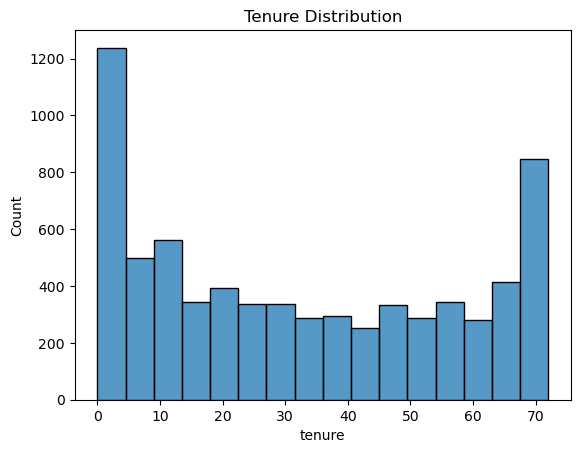

In [14]:
sns.histplot(df, x='tenure')
plt.title('Tenure Distribution')
plt.show()

- The tenure distribution is bimodal, showing two clear peaks: one for customers who stay between 0–5 months, and another for customers who stay 70+ months.

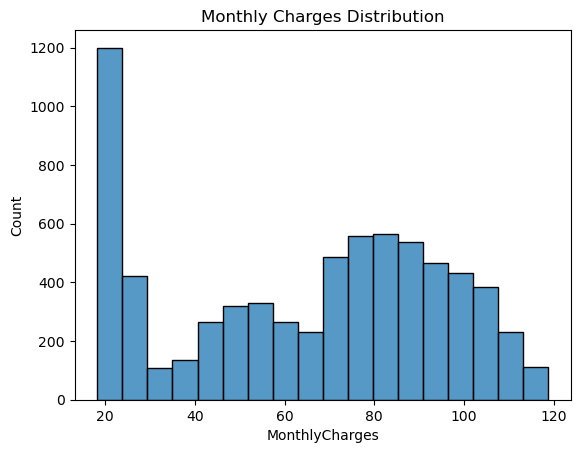

In [15]:
sns.histplot(df, x='MonthlyCharges')
plt.title('Monthly Charges Distribution')
plt.show()


* There is a clear spike at \$20, likely representing the cheapest plan. We want to examine whether these customers tend to stay longer because of the lower cost.
* There are also noticeable peaks around \\$70 and \$100, representing customers on higher-priced, premium plans who contribute more revenue. If those customers are leaving, this will hurt the bottom line much more than the \\\$20 group.


In [16]:
def countplot_ratio(
        x=None, data=None, hue=None, ax=None,
        order=None, autopct=True, color=None
    ):
    """
    Plot a countplot with proportions shown above each bar.
    """

    # Create axis if not provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))

    # Plot countplot
    sns.countplot(
        x=x, data=data, hue=hue,
        order=order, ax=ax, color=color
    )

    # Title
    var_name = x if isinstance(x, str) else "Variable"
    ax.set_title(f"{var_name} Distribution", fontsize=14, weight="bold")

    # Total used for percentages
    total = float(len(data))

    # Add percentages on bars
    if autopct:
        for patch in ax.patches:
            height = patch.get_height()
            if height > 0:
                ax.text(
                    patch.get_x() + patch.get_width() / 2,
                    height + (total * 0.001),     # small dynamic offset
                    f"{(height / total) * 100:.2f}%",
                    ha="center", va="bottom",
                    fontsize=11, weight="bold"
                )

    return ax


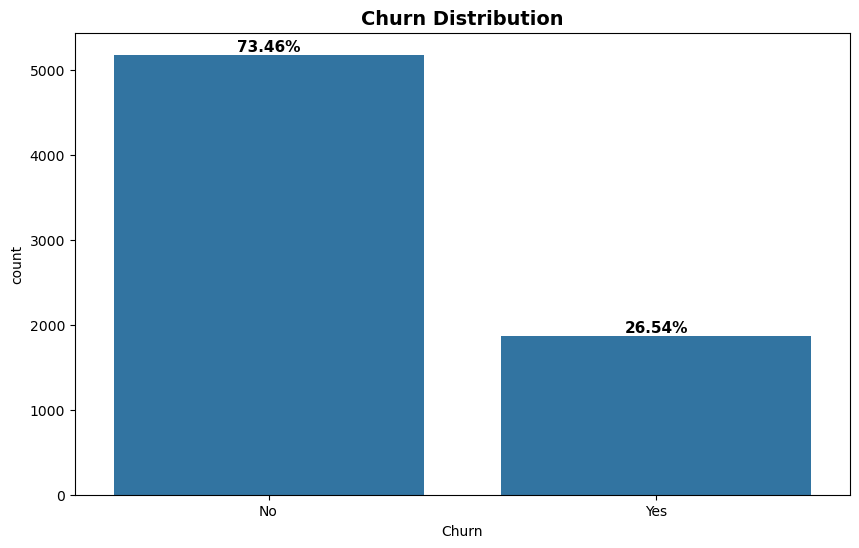

In [17]:
countplot_ratio('Churn', df)
plt.show()

- 26.5% of the customers churned.

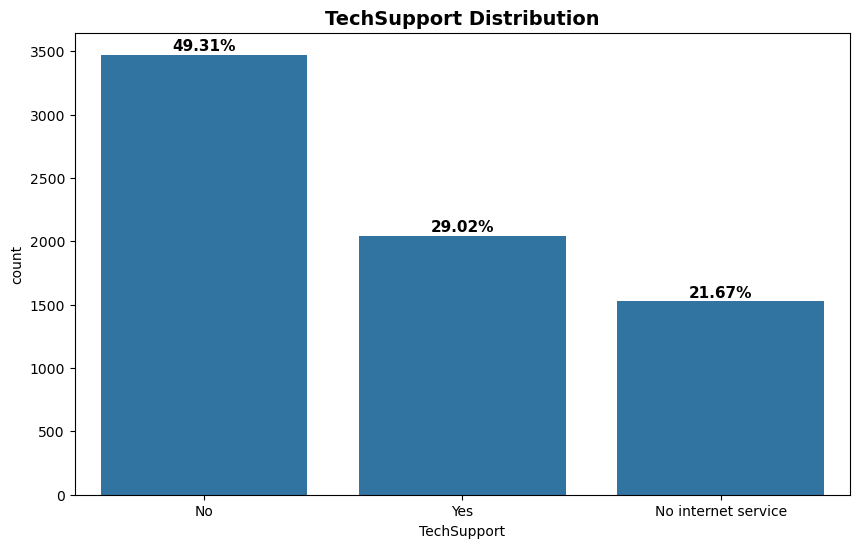

In [18]:
countplot_ratio('TechSupport', df)
plt.show()


* About 79% of the customers have internet service but do not pay for tech support.
* Only 29% of the customers use tech support.
* About 21.67% of the customers do not have internet service.


In [20]:
df.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [21]:
def plot_churn_rate(df, feature, target='Churn', hue=None, positive_class='Yes',
                    ax=None, colors=None):

    # Default colors
    if colors is None:
        colors = sns.color_palette("tab10")

    # Create axis
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))

    # ----------------------------
    # NO HUE CASE
    # ----------------------------
    if hue is None:
        # Normalized churn rate per feature
        ct = pd.crosstab(df[feature], df[target], normalize='index') * 100

        churn_rate = ct[positive_class]

        # Plot
        churn_rate.plot(kind='bar', ax=ax, color=colors[0], rot=0)

        # Labels
        ax.set_title(f'{target.title()} Rate by {feature.title()}', fontsize=13, weight='bold')
        ax.set_ylabel('Percentage (%)')
        ax.set_xlabel(feature.title())

        # Annotate bars
        for p in ax.patches:
            height = p.get_height()
            ax.text(
                p.get_x() + p.get_width() / 2,
                height + height * 0.02,
                f'{height:.1f}%',
                ha='center', va='center',
                color='black', fontweight='bold'
            )

        return ax

    # ----------------------------
    # HUE CASE
    # ----------------------------
    # Compute normalized churn per (feature × hue)
    ct = (
        df
        .groupby([feature, hue])[target]
        .value_counts(normalize=True)
        .mul(100)
        .rename('percentage')
        .reset_index()
    )

    # Keep only the positive class (e.g., Churn = Yes)
    ct = ct[ct[target] == positive_class]

    # Pivot for grouped bar plot
    plot_data = ct.pivot(index=feature, columns=hue, values='percentage')

    # Plot
    plot_data.plot(kind='bar', ax=ax, rot=0, color=colors)

    # Labels
    ax.set_title(f'{target.title()} Rate by {feature.title()} (Hue: {hue.title()})', fontsize=13, weight='bold')
    ax.set_ylabel('Percentage (%)')
    ax.set_xlabel(feature.title())
    ax.legend(title=hue.title())

    # Annotate bars
    for bars in ax.containers:
        for p in bars:
            height = p.get_height()
            if height > 0:
                ax.text(
                    p.get_x() + p.get_width() / 2,
                    height + height * 0.02,
                    f'{height:.1f}%',
                    ha='center', va='center',
                    color='black',
                    fontweight='bold'
                )

    return ax


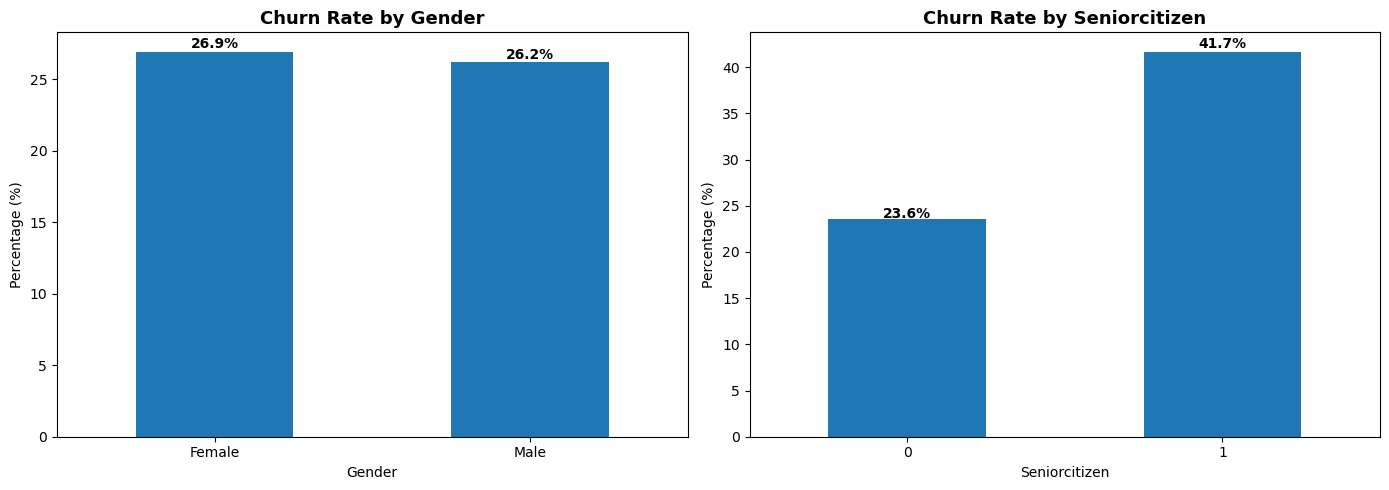

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
plot_churn_rate(df, 'gender', 'Churn', ax=ax[0])
plot_churn_rate(df, 'SeniorCitizen', 'Churn', ax=ax[1])
plt.tight_layout()
plt.show()

- There is no significant difference in churn rate between female and male customers, therefore, gender does not appear to have any impact on whether customers stay or leave.
- 41.7% of senior citizens churned, compared to 23.6% of non–senior citizens.

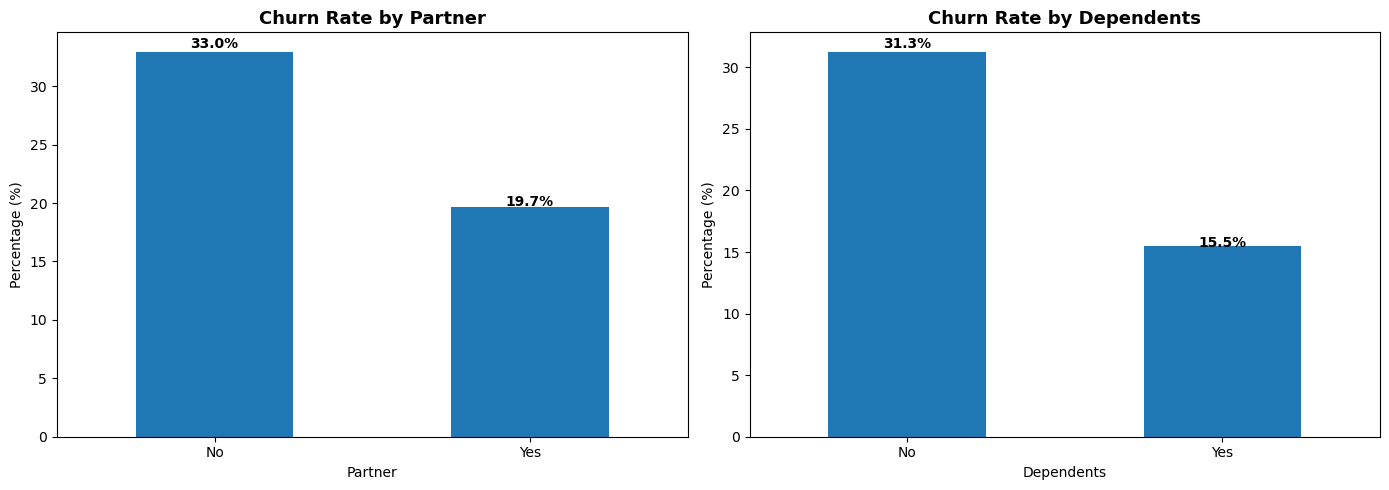

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
plot_churn_rate(df, 'Partner', 'Churn', ax=ax[0])
plot_churn_rate(df, 'Dependents', 'Churn', ax=ax[1])
plt.tight_layout()
plt.show()

* Customers without a partner are more likely to churn than those with a partner. About 33% of customers without a partner churned, compared to 19.7% of customers who have a partner.
* Customers without dependents are significantly more likely to churn than those with dependents. About 31.3% of customers without dependents churned, compared to 15.5% of customers who have dependents.

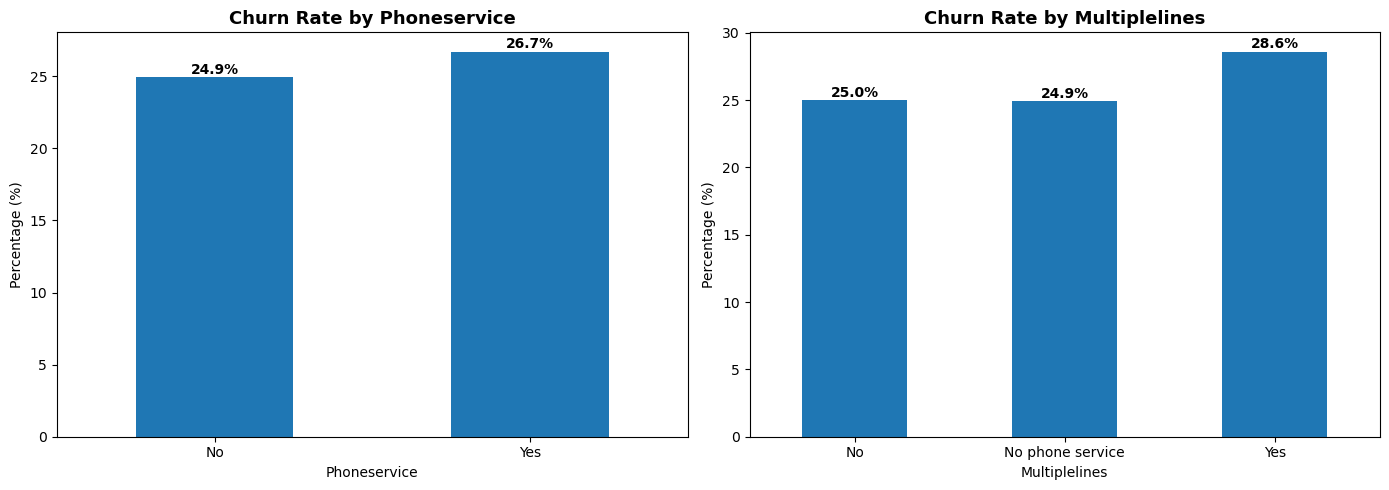

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
plot_churn_rate(df, 'PhoneService', 'Churn', ax=ax[0])
plot_churn_rate(df, 'MultipleLines', 'Churn', ax=ax[1])
plt.tight_layout()
plt.show()

- The churn rate for customers without phone service (24.9%) is nearly identical to those with it (26.7%). This indicates that the presence of a phone line is not a deciding factor in customer retention.

- Around 25% of customers without multiple lines churned, compared to 28.6% of those with multiple lines. The difference is small, suggesting that having multiple lines is also not a major predictor of churn.

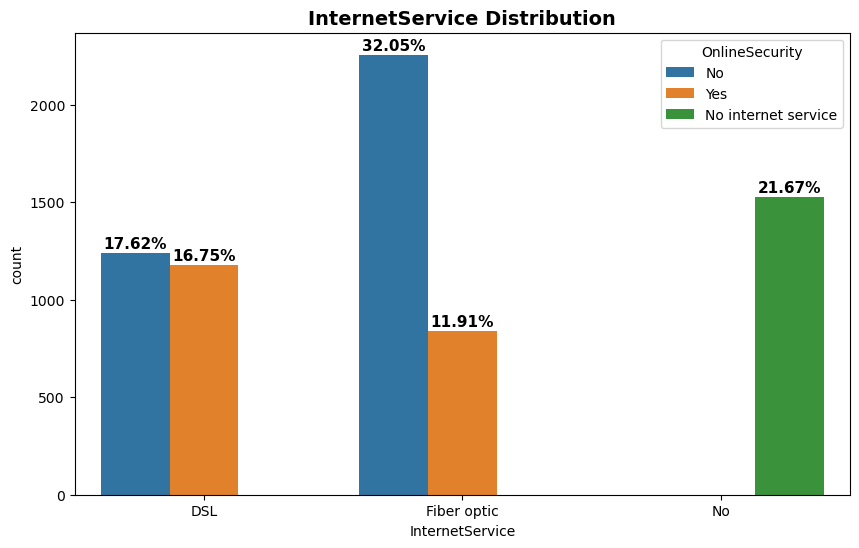

In [25]:
countplot_ratio(x='InternetService', data=df, hue='OnlineSecurity');

- Among DSL customers, the using of Online Security is nearly evenly split. Approximately 17.6% of the total customer base has DSL without security, while 16.8% has DSL with security. This suggests DSL users see moderate value in the add-on.
  
- There is a significant disparity among Fiber Optic users. While 32.05% of the total customer base pays for high-speed Fiber Optic internet, they do not subscribe to Online Security. In contrast, only 11.9% of Fiber users have the security add-on.

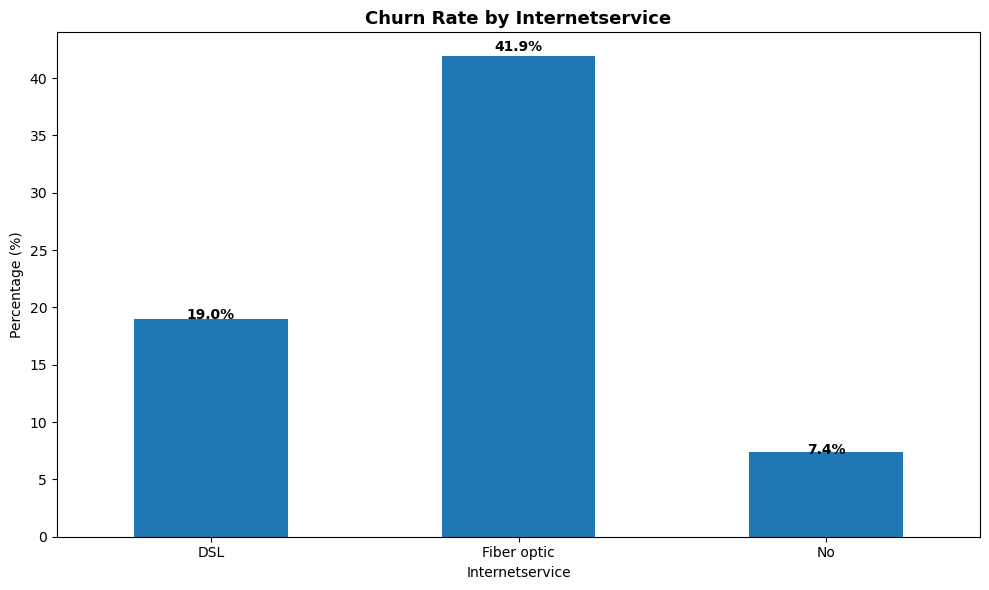

In [26]:
plot_churn_rate(df, 'InternetService', 'Churn')
plt.tight_layout()
plt.show()

- Despite being the superior technology, Fiber Optic customers exhibit a surprisingly high churn rate of 41.9%. This is more than double the churn rate of DSL users (19.0%).
- DSL users are significantly more stable, with a moderate churn rate of 19.0%. While the technology is older, these customers appear more loyal or perhaps have fewer alternatives in their area.

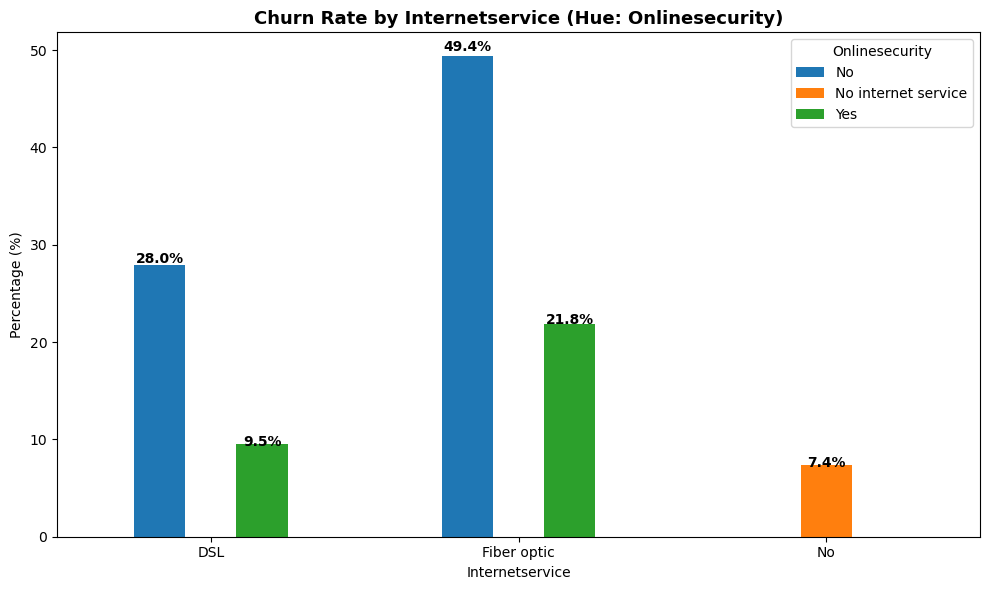

In [27]:
plot_churn_rate(df, 'InternetService', 'Churn', hue='OnlineSecurity')
plt.tight_layout()
plt.show()

- Regardless of the internet connection type (DSL or Fiber), customers without Online Security are significantly more likely to churn than those who have it.
    - DSL Users: Churn drops from 28.0% (No Security) to just 9.5% (With Security).
    - Fiber Optic Users: Churn drops from a massive 49.4% (No Security) to 21.8% (With Security).

- While Fiber Optic service itself is risky (high churn), bundling it with Online Security cuts the risk in half. This confirms that "value-added services" act as effective switching barriers.

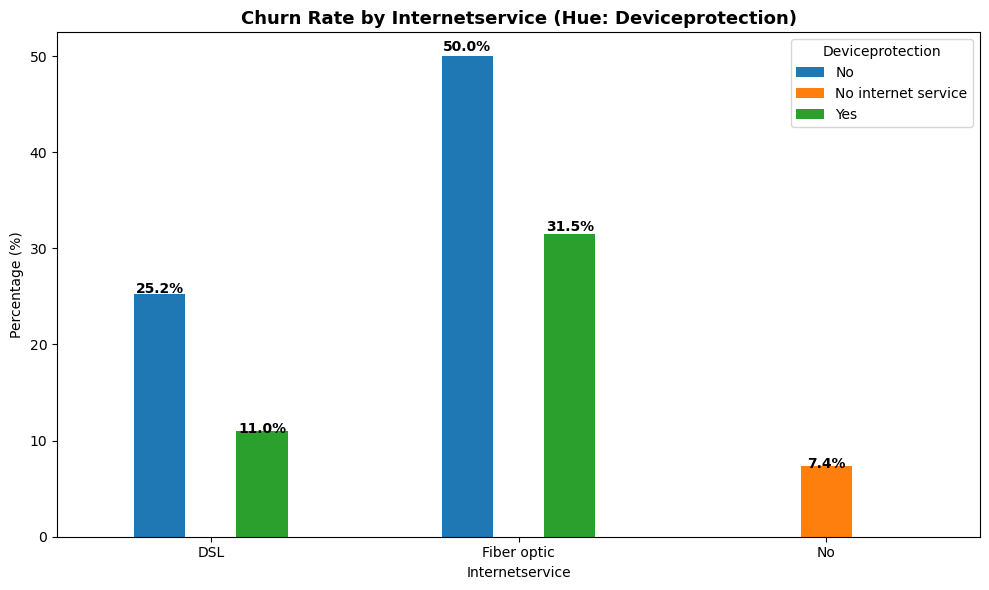

In [28]:
plot_churn_rate(df, 'InternetService', 'Churn', hue='DeviceProtection')
plt.tight_layout()
plt.show()

- Similar to Online Security, Device Protection acts as a strong retention driver across all internet types.
- For DSL customers, adding Device Protection significantly strengthens an already stable customer base, reducing churn from 25.2% to just 11.0%.
- Among Fiber Optic customers without protection, 50.0% churn. When Device Protection is added, churn drops substantially to 31.5%.

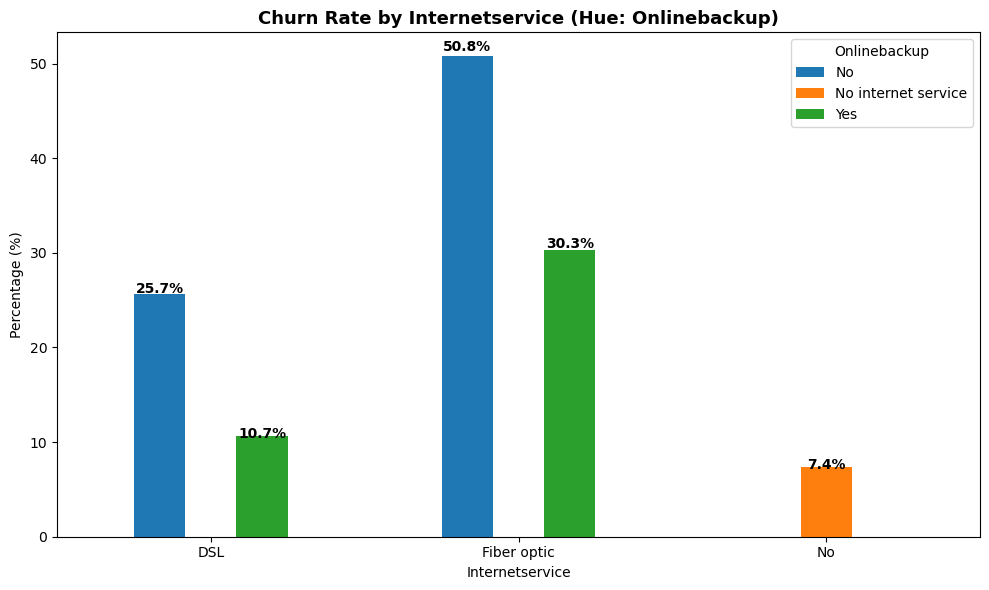

In [29]:
plot_churn_rate(df, 'InternetService', 'Churn', hue='OnlineBackup')
plt.tight_layout()
plt.show()

- Just like Security and Device Protection, Online Backup is a strong retention driver.
    - Fiber Optic Users: The churn rate drops significantly from 50.8% (No Backup) to 30.3% (With Backup).
    - DSL Users: The rate drops from 25.7% to just 10.7%.
- Across all three support services (Security, Backup, Device Protection), we observe a consistent trend: Using these services reduces churn by roughly 15-20 percentage points. This confirms that bundled customers are significantly stickier than those who only purchase raw connectivity.

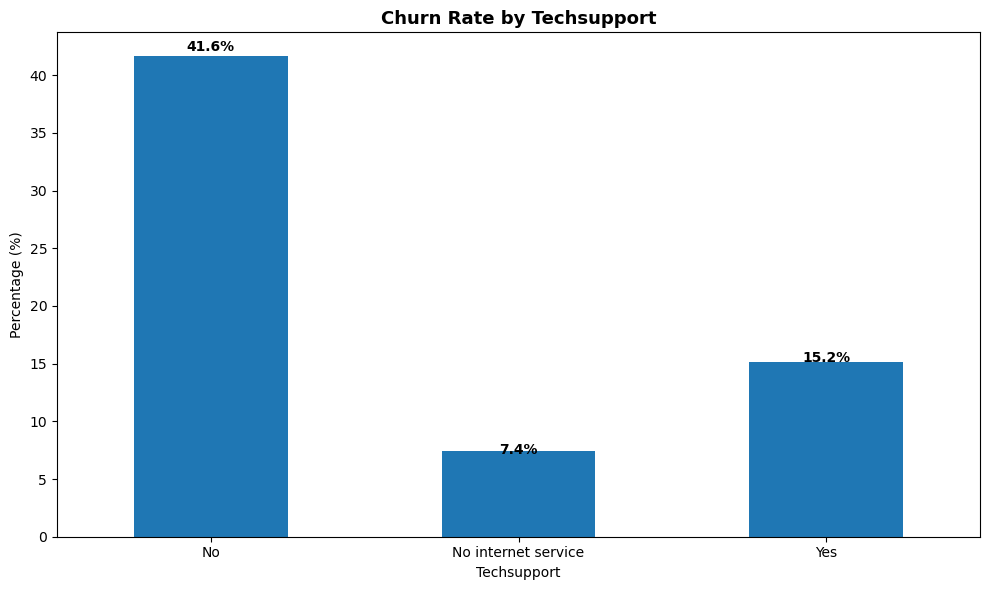

In [30]:
plot_churn_rate(df, 'TechSupport', 'Churn')
plt.tight_layout()
plt.show()

- Customers without Tech Support have a churn rate of 41.6%, whereas those with Tech Support have a churn rate of only 15.2%.

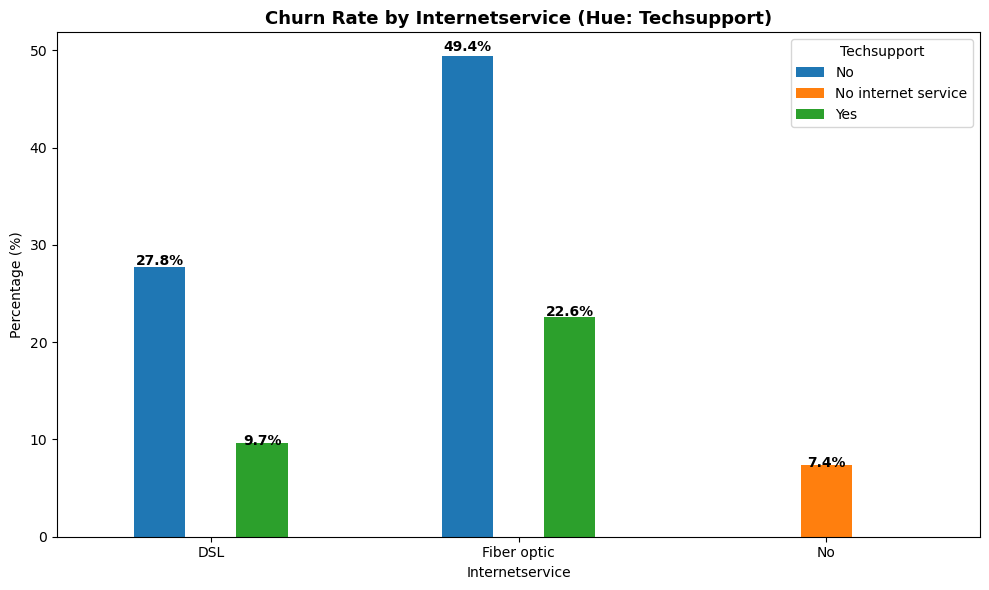

In [31]:
plot_churn_rate(df, 'InternetService', 'Churn', hue='TechSupport')
plt.tight_layout()
plt.show()

- Regardless of the internet connection type, Tech Support acts as a powerful retention tool.
    - DSL Users: Churn drops from 27.8% (No Support) to just 9.7% (With Support).
    - Fiber Optic Users: Churn drops from a critical 49.4% (No Support) to 22.6% (With Support).
- The most interesting statistic is the 49.4% churn rate for Fiber Optic customers without support. Essentially, half of these high-value customers leave. However, getting them to sign up for Tech Support cuts their churn rate in half (to 22.6%).

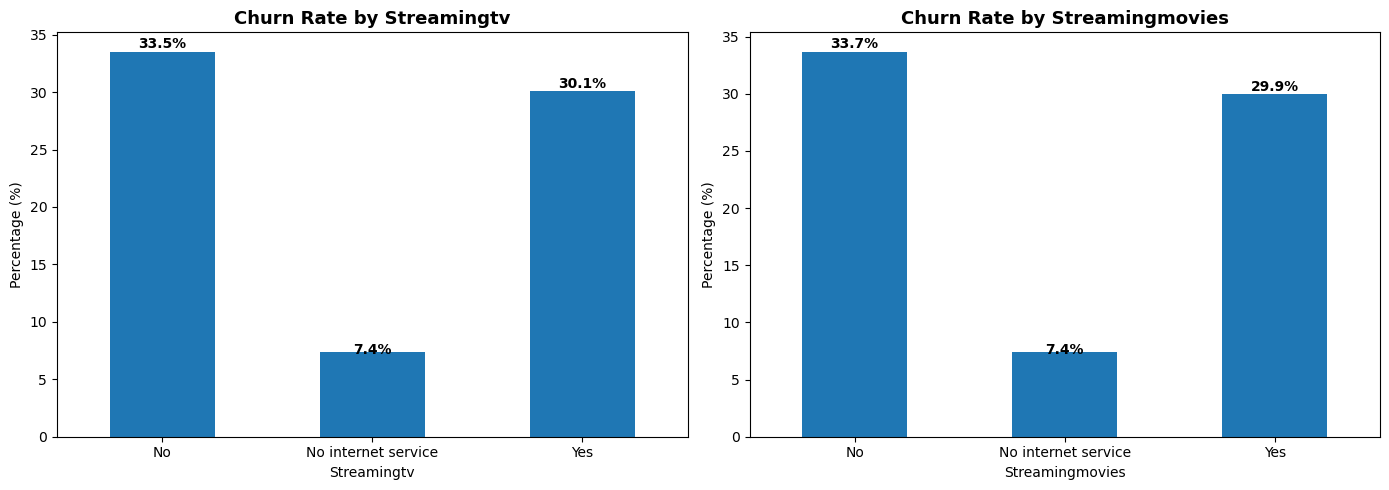

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
plot_churn_rate(df, 'StreamingTV', 'Churn', ax=ax[0])
plot_churn_rate(df, 'StreamingMovies', 'Churn', ax=ax[1])
plt.tight_layout()
plt.show()


* 33.5% of customers who don't subscribe to streaming TV churned, compared to 30.1% of those who do. The difference is very small, so this feature is unlikely to be a strong predictor of churn.
* Similarly, 33.7% of customers who don't subscribe to streaming movies churned, compared to 29.9% of those who do. Again, the difference is minimal, indicating that this feature is also not a strong predictor of churn.
* We might exclude both Streaming TV and Streaming Movies from the model.


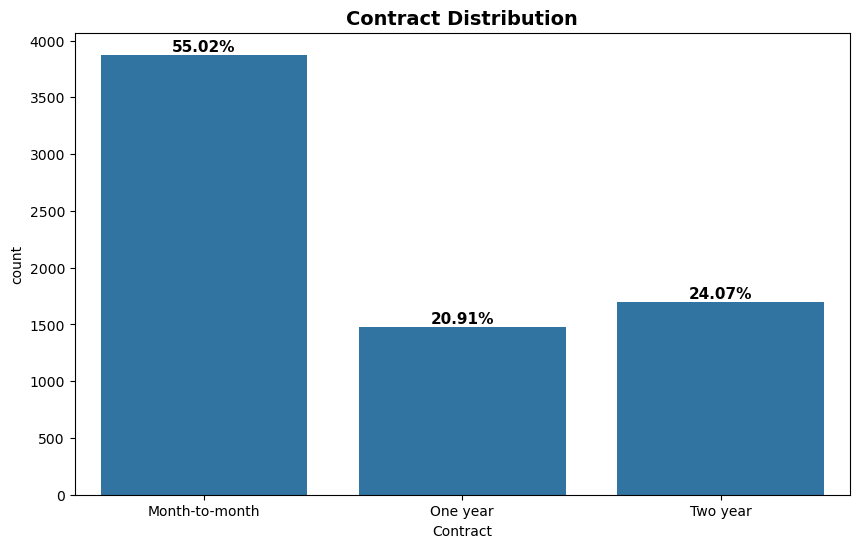

In [46]:
countplot_ratio(x='Contract', data=df)
plt.show()

- More than half (55.02%) of customers are on a Month-to-month contract.
- One-year contracts are the least popular option, accounting for only 20.91% of the customer base.
- Two-year contracts make up roughly 24.07% of customers, suggesting a segment of loyal, long-term users.    

<Axes: title={'center': 'Churn Rate by Contract'}, xlabel='Contract', ylabel='Percentage (%)'>

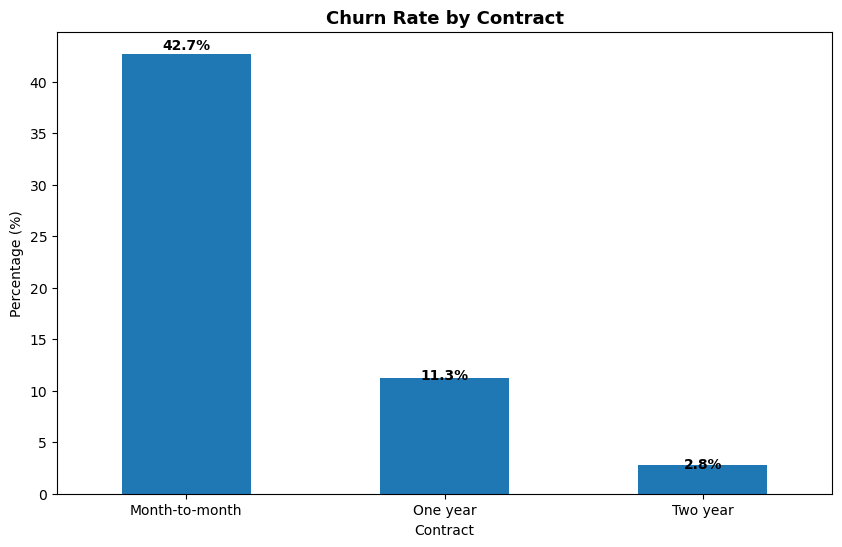

In [47]:
plot_churn_rate(df, 'Contract', 'Churn')

- 42.7% of customers on month-to-month contracts churned, compared to 11.3% of those on one-year contracts and 2.8% of those on two-year contracts.
- Most of our customer base is on month-to-month contracts, which also have the highest churn rate. We should focus on converting these customers to one-year or two-year contracts, as they are significantly less likely to churn.

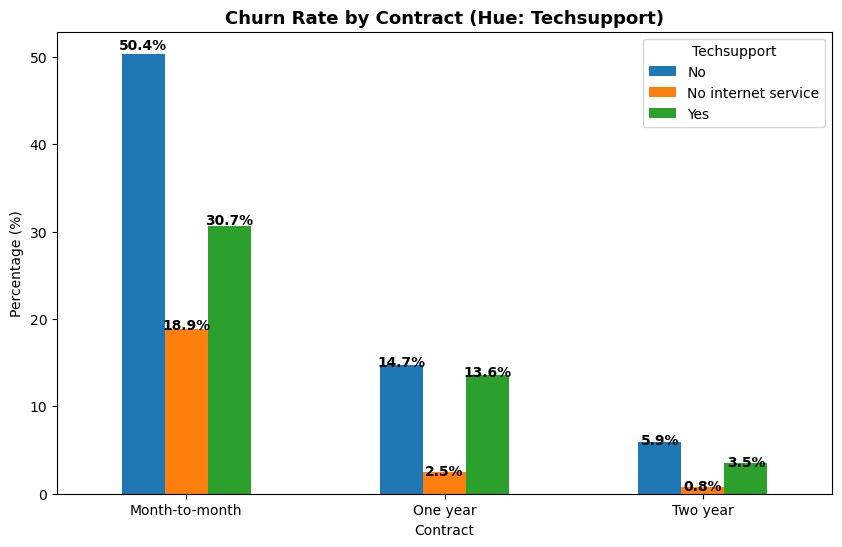

In [49]:
plot_churn_rate(df, 'Contract', 'Churn', hue='TechSupport');

* Customers on month-to-month contracts who do not have tech support exhibit a very high churn rate of 50.4%. In contrast, customers on month-to-month contracts who have tech support show a lower churn rate of 30.7%.
* While converting customers to long-term contracts is an effective solution, providing tech support to this segment can also significantly reduce churn.

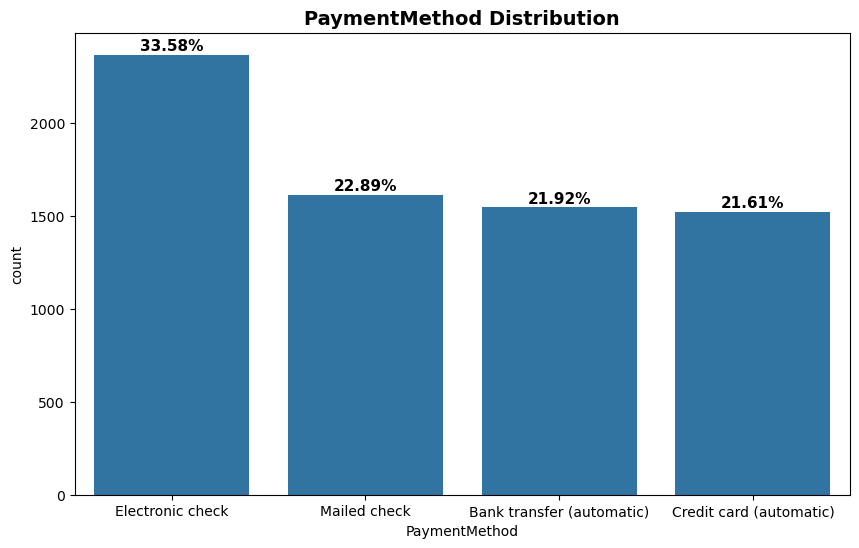

In [50]:
countplot_ratio(x='PaymentMethod', data=df)
plt.show()

- 33.58% of customers use electronic checks, while the other payment methods have a relatively similar distribution: 22.89% for mailed checks, 21.92% for bank transfer (automatic), and 21.61% for credit card (automatic).
- Electronic Check is the most popular payment method, used by 33.6% of your customers.

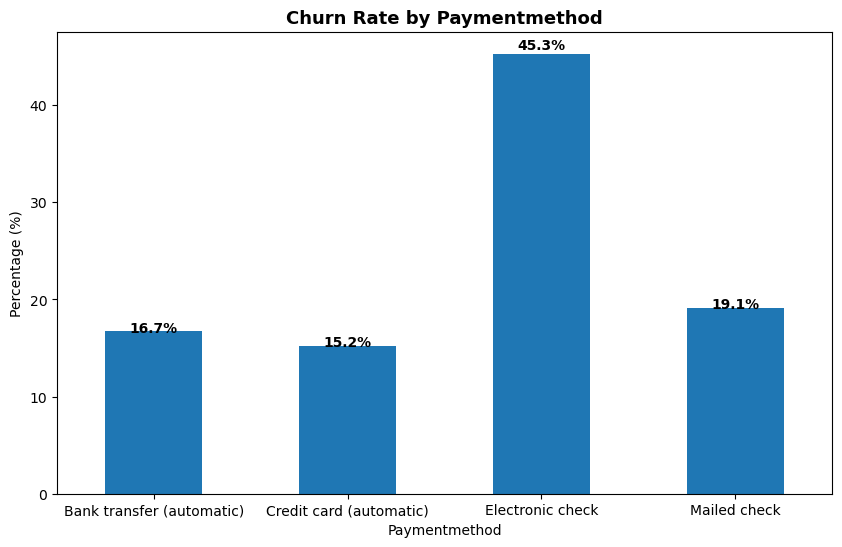

In [52]:
plot_churn_rate(df, 'PaymentMethod', 'Churn')
plt.show()

* While electronic check is the most popular payment method, it exhibits a 45.3% churn rate, which is much higher than other payment methods, whose churn rates do not exceed 20%.
* We need to incentivize users to use automatic payment methods rather than electronic checks, since they are associated with a lower churn rate.


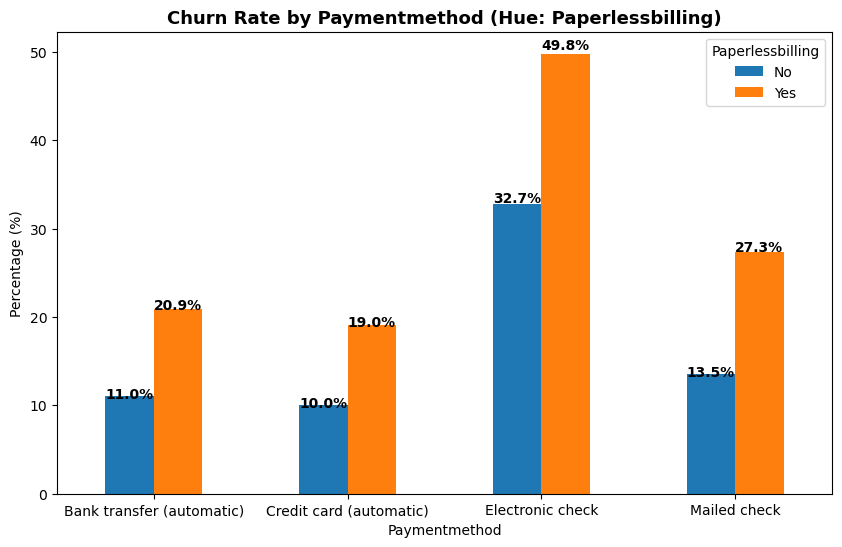

In [54]:
plot_churn_rate(df, 'PaymentMethod', 'Churn', hue='PaperlessBilling')
plt.show()

- Regardless of the payment method, customers who use paperless billing are more likely to churn than those who do not.


<Axes: xlabel='Churn', ylabel='MonthlyCharges'>

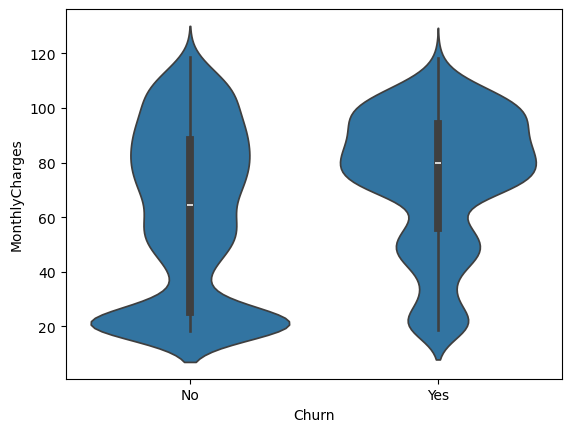

In [56]:
sns.violinplot(data=df, x='Churn', y='MonthlyCharges')


* **Non-churned customers:** The density is concentrated at the lower end, around **\$20**, indicating that a large share of retained customers are subscribed to low-cost, basic plans.
* **Churned customers:** The density shifts upward, clustering around **\$70–\\$100**, confirming that customers on higher-priced plans are significantly more likely to churn.

<Axes: xlabel='Contract', ylabel='MonthlyCharges'>

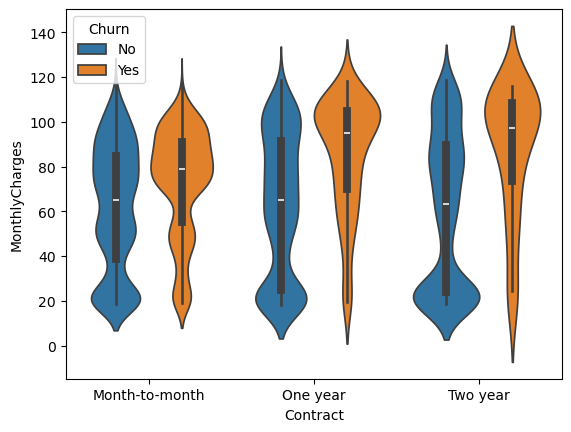

In [57]:
sns.violinplot(data=df, x='Contract', y='MonthlyCharges', hue='Churn')

- No matter what contract a customer signs, for those who churn, the distribution is often concentrated at the top (high monthly charges), whereas for those who do not churn, the distribution is concentrated at the bottom (low monthly charges).

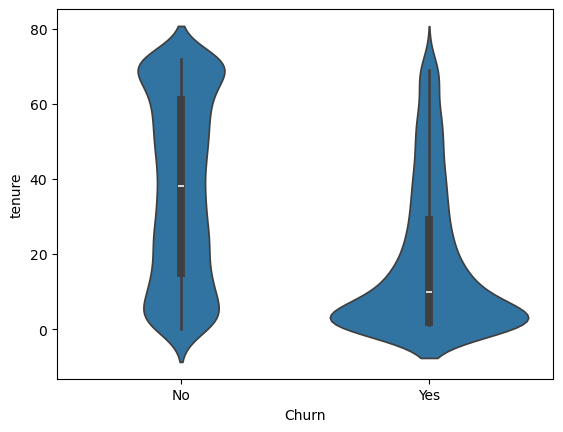

In [60]:
sns.violinplot(data=df, x='Churn', y='tenure');

- For those who churn, the distribution of tenure is concentrated at the bottom (low tenure), which means we are more likely to lose customers who have just joined the company.

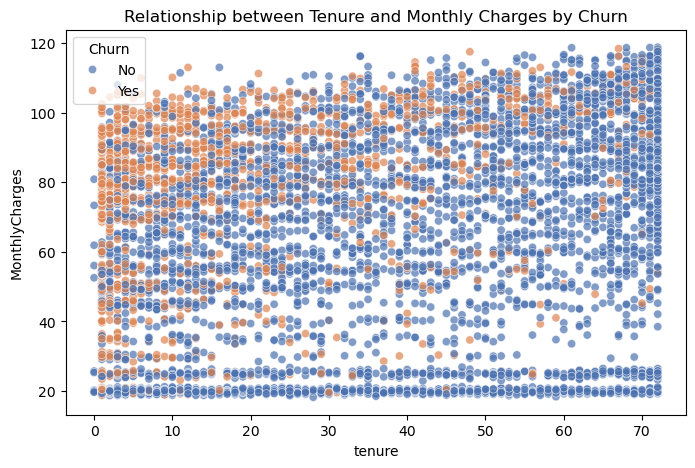

In [73]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x='tenure', y='MonthlyCharges', hue='Churn', alpha=0.7, palette='deep')
plt.title('Relationship between Tenure and Monthly Charges by Churn')
plt.show()

- From this chart we can see that there is no linear relationship between tenure and monthly charges. 
- Churned customers are concentrated at tenure less than 20 months and monthly charges greater than $70. This confirms that New Customers on Expensive Plans are the most fragile segment. They sign up, get hit with a big bill, experience a service failure (no tech support), and leave immediately.

# **EDA Conclusion**

After performing a thorough exploratory data analysis, several clear patterns emerge that explain why customers churn and, more importantly, what keeps them loyal.

Overall, churn is not driven by demographic factors such as gender, phone service, or multiple lines, as these show minimal differences between churned and retained customers. Instead, churn is primarily driven by **contract type, pricing, service quality, and the presence of value-added services**.

The analysis shows that **month-to-month contracts are the core churn problem**. They make up the majority of the customer base and exhibit dramatically higher churn rates, especially when combined with **high monthly charges** and **lack of tech support**. New customers on expensive plans are the most fragile segment, particularly Fiber Optic users, where churn can reach nearly 50% if no support services are included.

At the same time, **value-added services (Online Security, Device Protection, Online Backup, and Tech Support)** consistently reduce churn by large margins across all internet types. This effect is especially strong for Fiber Optic customers, where bundling these services cuts churn nearly in half. This confirms that customers who buy bundles are significantly “stickier” than those who only purchase raw connectivity.

Payment behavior also plays an important role. **Electronic check users churn at much higher rates**, while automatic payment methods are associated with stronger retention. Similarly, customers on **higher-priced plans churn more**, while those on low-cost plans tend to stay, regardless of contract length.

In summary, churn is **structural, not random**. It is driven by pricing shocks, weak onboarding, lack of support, and short-term commitments. The most effective levers to reduce churn are:

* Converting month-to-month customers to long-term contracts
* Bundling Fiber Optic plans with support and protection services
* Encouraging automatic payment methods
* Protecting new, high-paying customers during their early tenure

Focusing on these areas will directly target the highest-risk segments and deliver the greatest impact on customer retention.


# Hypothesis Testing
##### Statistical Methodology: Bootstrap Resampling
- **Key Assumption:** We assume that the available dataset is representative of the true population of Telco customers.

- **The Method:** Instead of relying on traditional parametric tests (like the T-test) which assume the data follows a strict Normal Distribution, we employ Bootstrap Resampling.

### **Test 1: Multiple Lines vs. Single Line**

**Objective:** Let's make sure the difference in churn between single-line and multiple-line customers is statistically significant and not due to chance.

#### **Formulating the Hypotheses**

* **Null Hypothesis ($H_0$):**
    $$P_{\text{multiple}} - P_{\text{single}} = 0$$
There is no difference in churn rate between single-line customers and multiple-line customers. Any observed difference is random noise.

* **Alternative Hypothesis ($H_1$):**
    $$P_{\text{multiple}} - P_{\text{single}} \neq 0$$
There is a statistically significant difference in churn rate between single-line customers and multiple-line customers.

In [33]:
group_single = df[df['MultipleLines'] == 'No']['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)
group_multi = df[df['MultipleLines'] == 'Yes']['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

In [34]:
obs_diff_line_churn = group_multi.mean() - group_single.mean()

print(f"Observed Difference in Churn Rate: {obs_diff_line_churn:.4f} ({(obs_diff_line_churn*100):.2f}%)")

Observed Difference in Churn Rate: 0.0357 (3.57%)


In [35]:
line_churn_diffs = []
for _ in range(10_000):
    single_line_sample = group_single.sample(len(group_single), replace=True)
    multi_line_sample = group_multi.sample(len(group_single), replace=True)
    line_churn_diffs.append(multi_line_sample.mean() - single_line_sample.mean())

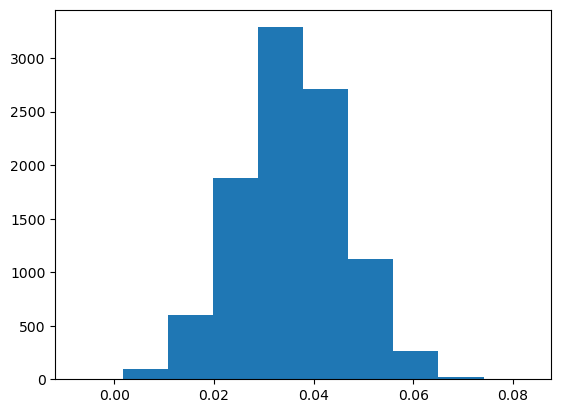

In [36]:
plt.hist(line_churn_diffs);

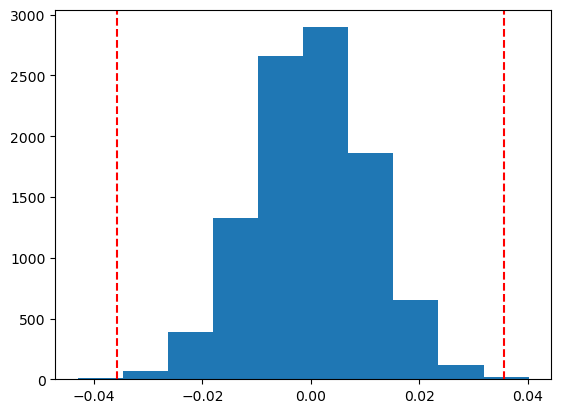

In [37]:
null_mean = 0

null_vals = np.random.normal(null_mean, np.std(line_churn_diffs), 10_000)

lower_bound = null_mean - abs(null_mean - obs_diff_line_churn)
upper_bound = null_mean + abs(null_mean - obs_diff_line_churn)

plt.hist(null_vals)
plt.axvline(lower_bound, color='r', linestyle='--')
plt.axvline(upper_bound, color='r', linestyle='--')
plt.show()

In [38]:
alpha = 0.05

p_value = (null_vals <= lower_bound).mean() + (upper_bound <= null_vals).mean()
print('P-value: ', p_value)

P-value:  0.0009


- The Bootstrap test returned a P-value < 0.05, leading us to reject the Null Hypothesis. There is a statistically significant difference in churn behavior between Single-Line and Multi-Line customers.
- However, the observed difference in churn rate is only 3.6% (25.0% vs 28.6%). While "Multiple Lines" is a verified predictor, its effect size is small.
- We will include this feature in the predictive model, but we do not recommend prioritizing it for immediate retention campaigns compared to high-impact drivers.

### **Test 2: Tech Support vs. No Tech Support**

**Objective:** Determine whether the difference in churn between customers with tech support and those without tech support is statistically significant rather than due to random chance.

#### **Formulating the Hypotheses**

* **Null Hypothesis ($H_0$):**
  $$P_{\text{no}} - P_{\text{tech}} = 0$$
There is no difference in churn rate between customers with tech support and those without tech support. Any observed difference is due to random variation.

* **Alternative Hypothesis ($H_1$):**
  $$P_{\text{no}} - P_{\text{tech}} \neq 0$$
There is a statistically significant difference in churn rate between customers with tech support and those without tech support.

In [39]:
group_no_tech_supp = df[df['TechSupport'] == 'No']['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)
group_tech_supp = df[df['TechSupport'] == 'Yes']['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

In [40]:
obs_supp_churn_diff = group_no_tech_supp.mean() - group_tech_supp.mean()
obs_supp_churn_diff

0.2646913314509527

In [41]:
support_churn_diffs = []
for _ in range(10_000):
    supp_sample = group_tech_supp.sample(len(group_tech_supp), replace=True)
    no_supp_sample = group_no_tech_supp.sample(len(group_no_tech_supp), replace=True)
    support_churn_diffs.append(no_supp_sample.mean() - supp_sample.mean())

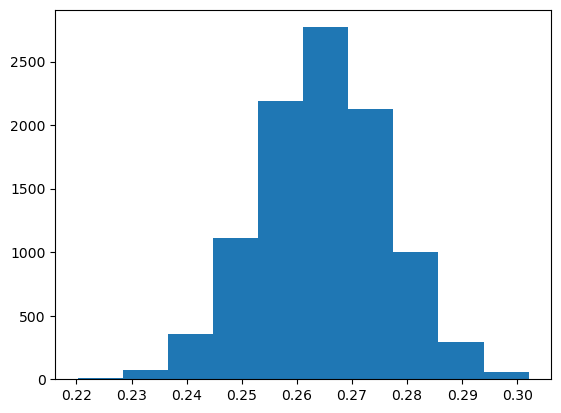

In [42]:
plt.hist(support_churn_diffs);

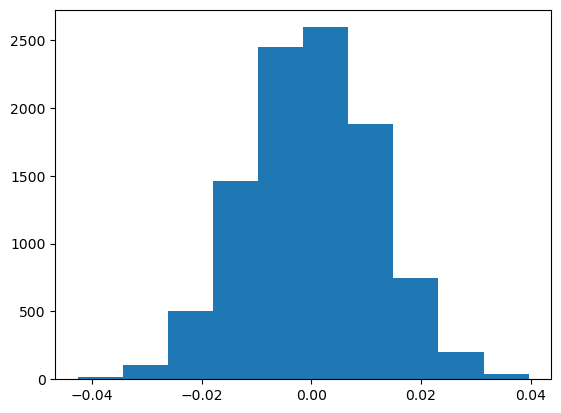

In [43]:
null_mean = 0
null_vals = np.random.normal(null_mean, np.std(support_churn_diffs), 10_000)

plt.hist(null_vals)
plt.show()

In [44]:
lower = null_mean - abs(null_mean - obs_supp_churn_diff)
upper = null_mean + abs(null_mean - obs_supp_churn_diff)

p_value = (null_vals < lower).mean() + (upper < null_vals).mean()
print(p_value)

0.0


- The bootstrap test returned a P-value of 0.0, meaning there is essentially zero probability that the difference in churn rates occurred by chance. We confidently Reject the Null Hypothesis.
- Unlike "Multiple Lines" (where the difference was real but tiny), `TechSupport` shows a massive 26.4% gap in retention.
    - No Tech Support Churn: ~41.6%
    - With Tech Support Churn: ~15.2%

# Quantifying Churn Drivers with Logistic Regression

Based on the EDA results, here is the final selection of features (variables) to feed into the Logistic Regression model.


**Selected Features:**

```
tenure, MonthlyCharges, Contract, InternetService, PaymentMethod, TechSupport, OnlineSecurity, PaperlessBilling, OnlineBackup, DeviceProtection, Partner, Dependents
```

**Dropped Features:**

```
gender, PhoneService, MultipleLines, StreamingTV, StreamingMovies, customerID
```

# Comming Next